<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/14_6_2_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import numpy as np
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
from pandas import DataFrame
from pandas import read_csv
import matplotlib.pyplot as plt


In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [3]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  #print(data.shape)
  df = DataFrame(data)
  #print(df)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    #print(cols)
  # put it all together
  agg = concat(cols, axis=1)
  
  #print(agg)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  #agg.fillna(0)
  #print(agg)
  return agg.values


In [4]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

In [5]:
# fit a model
def model_fit(train, config):
  # unpack config
  n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
  n_input = n_seq * n_steps
  # prepare data
  data = series_to_supervised(train, n_input)
  #print(data.shape)
  train_x, train_y = data[:, :-1], data[:, -1]
  #print("-train'")
  #print(train_x)
  train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
  #print(train_x.shape)
  
  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
  activation='relu', input_shape=(None,n_steps,1))))
  model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
  activation='relu')))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(n_nodes, activation='relu'))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  #print(train_x)
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

In [6]:
# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_seq, n_steps, _, _, _, _, _ = config
  n_input = n_seq * n_steps
  # prepare data
  x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]

In [7]:
# make predictions on test set
def make_predictions(train, test, model, cfg):

  predictions = list()
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    #print(yhat[0])
    # store forecast in list of predictions
    predictions.append(yhat[0])
    # add predicted observation to history for the next loop
    history.append(yhat)

  return predictions

Read dataset

In [8]:
df = read_csv('/content/RevenueJuly.csv')
series = DataFrame(df['Revenue'])

In [9]:
series

,Revenue
0,11141.566
1,11483.520
2,89026.192
3,7486.732
4,17719.978
5,159129.659
6,16736.302
7,25432.066
8,145620.785
9,24954.743


In [10]:
series.shape

(55, 1)

In [11]:
data = series.values
data.shape

(55, 1)

In [12]:
#train-test split
# first 48 months make the training set and remaining 7 months make test set
n_test = 7
train = data[:-n_test]
test = data[-n_test:]

In [13]:
train.shape , test.shape

((48, 1), (7, 1))

In [14]:
# define config
# n_seq: The number of subsequences within a sample.
# n_steps: The number of time steps within each subsequence.
# n_filters: The number of parallel filters.
# n_kernel: The number of time steps considered in each read of the input sequence.
# n_nodes: The number of LSTM units to use in the hidden layer.
# n_epochs: The number of times to expose the model to the whole training dataset.
# n_batch: The number of samples within an epoch after which the weights are updated.
config = [1, 4, 16, 1, 64, 20, 12]

In [15]:
# build and fit model
model = model_fit(train, config)

In [16]:
# make predictions
predictions = make_predictions(train,test,model,config)

In [17]:
predictions

[41616.02, 38263.68, 198192.42, 250137.77, 21522.398, 56112.996, 109080.055]

In [18]:
test

array([[ 16507.335],
       [ 55265.293],
       [132267.597],
       [ 20550.787],
       [ 45757.982],
       [183715.237],
       [ 74225.599]])

In [19]:
#Evaluate Model using r2_score and RMSE
MSE = mean_squared_error(test, predictions)
RMSE = int(sqrt(MSE))
R2 = r2_score(test,predictions)
print('RMSE : ' + str(RMSE))
print('R square : ' + str(R2))

RMSE : 104238
R square : -2.346502069951753


Adding Graph

In [20]:
#set x axis labels
vis = dict()

x_axis_label = []

for cur_year in df['Year']:
  if str(cur_year) not in vis.keys():
    vis[str(cur_year)] = 1
    x_axis_label.append(str(cur_year))
  
  else:
    x_axis_label.append('')
  

In [21]:
x_axis_label

['2017',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2018',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2019',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2020',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2021',
 '',
 '',
 '',
 '',
 '',
 '']

Specify dates for training and test sets separately

In [22]:
dates_train = []
for i in range(len(df)-n_test):
  dates_train.append( str(df['Year'][i]) + "-" + str(df['Month'][i]) )

dates_train

['2017-1',
 '2017-2',
 '2017-3',
 '2017-4',
 '2017-5',
 '2017-6',
 '2017-7',
 '2017-8',
 '2017-9',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-1',
 '2018-2',
 '2018-3',
 '2018-4',
 '2018-5',
 '2018-6',
 '2018-7',
 '2018-8',
 '2018-9',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-1',
 '2019-2',
 '2019-3',
 '2019-4',
 '2019-5',
 '2019-6',
 '2019-7',
 '2019-8',
 '2019-9',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-1',
 '2020-2',
 '2020-3',
 '2020-4',
 '2020-5',
 '2020-6',
 '2020-7',
 '2020-8',
 '2020-9',
 '2020-10',
 '2020-11',
 '2020-12']

In [23]:
dates_test = []
for i in range(len(df)-n_test , len(df)):
  dates_test.append( str(df['Year'][i]) + "-" + str(df['Month'][i]) )

dates_test

['2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7']

Compute confidence/prediction intervals

In [24]:
x_bar = array(test).mean()

In [25]:
sum = 0
for i in range(n_test):
  t = (test[i]-x_bar)**2
  sum = sum + t

In [26]:
def compute_std_error(xh):
  temp1 = 1.0 + (1.0/n_test) 
  temp2 = float((xh - x_bar)**2) / sum
  return sqrt(MSE * (temp1+temp2))

In [27]:
confidence_upper = []
confidence_lower = []
t_multiplier = 2.228

In [28]:
for i in range(n_test):
  std_error = compute_std_error(test[i])
  val = t_multiplier * std_error
  confidence_upper.append(predictions[i] + val)
  temp = predictions[i] - val
  confidence_lower.append(max(temp,0))

In [29]:
confidence_upper

[305989.2994850592,
 288486.7263808753,
 461438.44193276024,
 512436.17897351214,
 273985.8657383919,
 355193.1871325846,
 357367.1115991019]

Plot graph

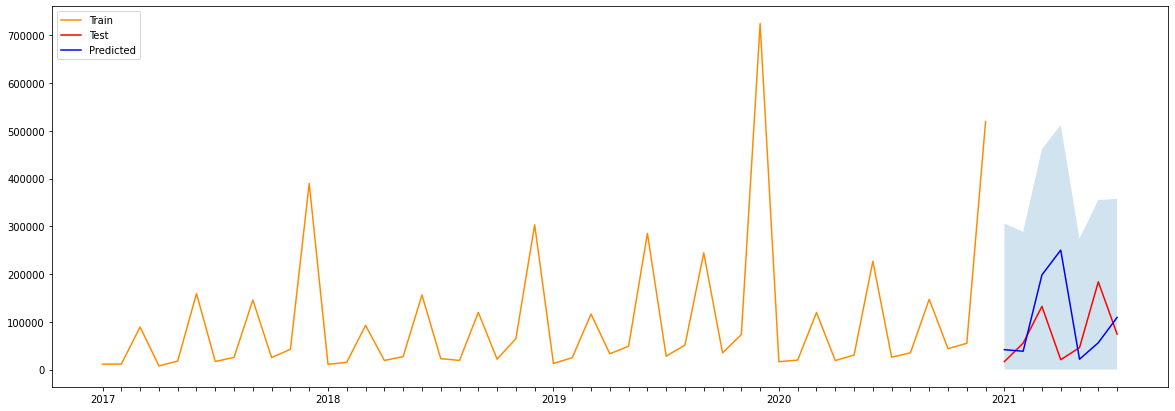

In [30]:
plt.figure(figsize=(20,7))
plt.plot(dates_train, train, color='darkorange', label="Train")
plt.plot(dates_test, test, color='red', label="Test")
plt.plot(dates_test, predictions, color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()